In [7]:
from Functions._analyzeData import *
from Functions._editDatabase import getTransactionData, getAccount
from Functions._Variables import typeMapping

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

In [8]:
myAcc = getAccount("atlas")

myAcc.summary()


                        Username: atlas
                        Password: 1912766d6ba0e50e8b1bacfb51207e83b95b7ac0cd8ce15307cdf4965e7e3f6c
                    Date Created: 2024-07-28 13:26:37
                    Date Updated: 2024-07-28 13:26:37
                         Balance: 10000000
        


In [9]:
df = getTransactionData(myAcc)

df

,TRANSACTION_ID,USERNAME,ITEM,TYPE,CATEGORY,VALUE,CREATED_AT,UPDATED_AT
0,98e255ba-825b-4e59-9397-3716aead4ff6,atlas,Nasi Rawon,0,0,25000,2023-01-04 16:40:45,2023-01-04 16:40:45
1,04154bbc-28b8-4356-ba68-8c1a279badfc,atlas,Lontong Sayur,0,0,15000,2011-02-24 17:04:06,2011-02-24 17:04:06
2,792fa506-c6f8-4699-86e5-7d0038559aed,atlas,Jus Semangka,0,0,15000,2010-02-10 23:36:04,2010-02-10 23:36:04
3,579fc1f0-9023-4c92-9c67-95512212c385,atlas,Bakmi Jawa,0,0,20000,2006-03-22 17:55:32,2006-03-22 17:55:32
4,38c9cf6d-2e73-4904-b6a5-ab52d20e8b7d,atlas,Nasi Timbel,0,0,20000,2008-08-23 20:02:48,2008-08-23 20:02:48
...,...,...,...,...,...,...,...,...
70115,0bd833e4-5d67-44bb-8c4a-8f516fb65e9e,atlas,Sate Kambing,0,0,35000,2015-03-14 01:35:41,2015-03-14 01:35:41
70116,071b11e9-07ed-4bc9-93af-3bce000c0cea,atlas,Jus Alpukat,0,0,15000,2005-10-25 08:21:12,2005-10-25 08:21:12
70117,459beb06-6f1d-4832-9b7f-43f7e0647dd9,atlas,Es Pisang Ijo,0,0,15000,2005-10-05 00:39:47,2005-10-05 00:39:47
70118,5c26b705-b3c0-4a75-9f6b-974f4f045e16,atlas,Ikan Goreng,0,0,20000,2022-11-04 22:06:43,2022-11-04 22:06:43


In [10]:
DATA = getTimeCycle(df, "year")
revenue = DATA[('Revenue', 'TOTAL')]
expenses = DATA[('Expenses', 'TOTAL')]

DATA

Expenses                                                     Revenue  \
             0        2        1        3            5         4        11   
YEAR                                                                         
2000  41478000  4340000  6420000  1550000   50000000.0       0.0  14000000   
2001  40780000  4810000  5950000  2250000          0.0       0.0  22000000   
2002  39985000  6170000  5355000  2400000  550000000.0  450000.0  14000000   
2003  39982000  5620000  5880000  1550000   50000000.0  600000.0  15000000   
2004  41157000  5070000  6745000  2350000          0.0  600000.0  37000000   
2005  39916000  4345000  6775000  3300000          0.0  150000.0  10000000   
2006  40387000  3510000  5720000  1300000   50000000.0  150000.0  35000000   
2007  41107000  4380000  5765000  2500000   50000000.0  150000.0  25000000   
2008  39692000  5070000  5740000  4100000   50000000.0  150000.0  26000000   
2009  39820000  3810000  5940000  1600000   50000000.0       0.0   2000000   
2010  39465000  5685000  6130000  3000000   50000000.0  450000.0  15000000   
2011  40772000  5475000  6020000  2650000   50000000.0  600000.0  32000000   
2012  40944000  4945000  6350000  2100000          0.0  300000.0  14000000   
2013  40259000  6060000  6280000  2000000          0.0  600000.0  17000000   
2014  39797000  3315000  6695000  2700000          0.0  150000.0   7000000   
2015  39283000  4780000  6075000  2350000  100000000.0  300000.0  15000000   
2016  40321000  5260000  5860000  2250000  100000000.0  600000.0         0   
2017  40575000  4775000  5740000  2350000   50000000.0  450000.0  23000000   
2018  40433000  5120000  6090000  2650000   50000000.0  300000.0  20000000   
2019  40437000  5020000  6640000  2850000  100000000.0  150000.0   9000000   
2020  39377000  5485000  5890000  1750000          0.0       0.0  14000000   
2021  38456000  4720000  6330000  2250000   50000000.0  150000.0   9000000   
2022  40148000  5015000  5150000  2300000  600000000.0  600000.0  14000000   
2023  40663000  5315000  5275000  1200000          0.0  300000.0  24000000   

                                        Expenses    Revenue        TOTAL  
            12         10        13        TOTAL      TOTAL               
YEAR                                                                      
2000   9000000   78000000   4000000  103788000.0  105000000    1212000.0  
2001   9000000  122000000   4000000   53790000.0  157000000  103210000.0  
2002  15000000  172000000   6000000  604360000.0  207000000 -397360000.0  
2003  21000000  104000000   7000000  103632000.0  147000000   43368000.0  
2004  24000000  128000000  11000000   55922000.0  200000000  144078000.0  
2005  15000000  106000000   8000000   54486000.0  139000000   84514000.0  
2006   9000000   78000000  14000000  101067000.0  136000000   34933000.0  
2007  24000000  124000000   2000000  103902000.0  175000000   71098000.0  
2008  24000000  124000000   4000000  104752000.0  178000000   73248000.0  
2009  18000000  102000000   8000000  101170000.0  130000000   28830000.0  
2010   9000000  120000000   8000000  104730000.0  152000000   47270000.0  
2011  15000000  100000000   7000000  105517000.0  154000000   48483000.0  
2012  12000000  104000000   6000000   54639000.0  136000000   81361000.0  
2013   9000000   90000000   3000000   55199000.0  119000000   63801000.0  
2014   9000000  166000000   2000000   52657000.0  184000000  131343000.0  
2015   9000000   58000000   4000000  152788000.0   86000000  -66788000.0  
2016  12000000   84000000   9000000  154291000.0  105000000  -49291000.0  
2017  12000000  158000000   7000000  103890000.0  200000000   96110000.0  
2018  18000000  116000000  13000000  104593000.0  167000000   62407000.0  
2019   9000000   92000000   7000000  155097000.0  117000000  -38097000.0  
2020   9000000   58000000   3000000   52502000.0   84000000   31498000.0  
2021  27000000   86000000   3000000  101906000.0  125000000   23094000.0  
2022   3000000  13600000

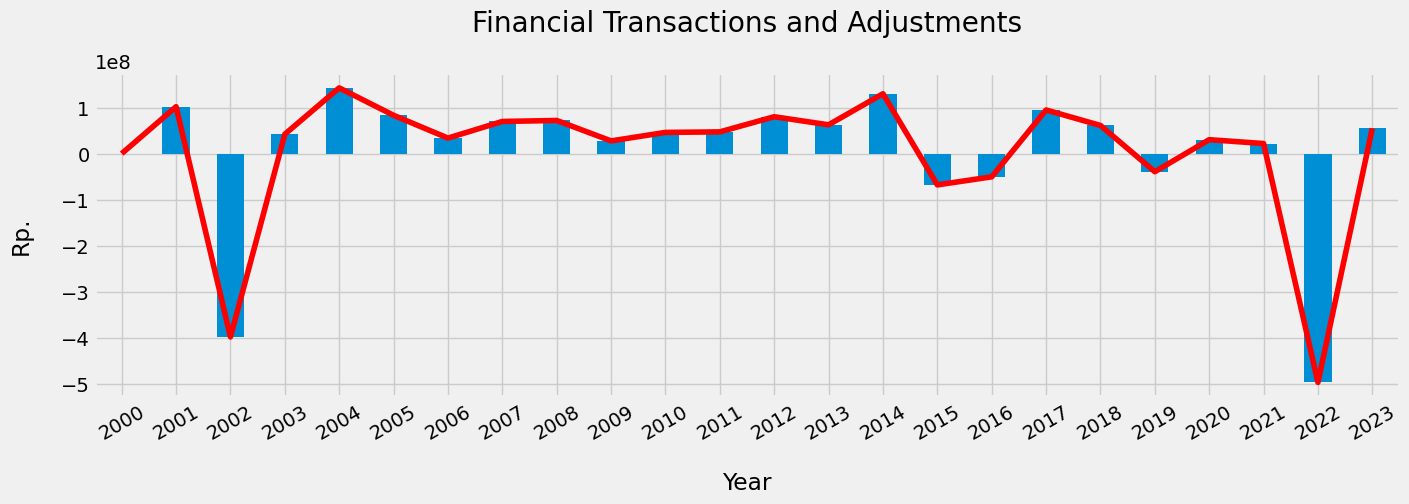

In [11]:
DATA['TOTAL'].plot(kind='bar', figsize=(15, 4))
DATA['TOTAL'].plot(color='red')
plt.grid(True, axis='y')
plt.title("Financial Transactions and Adjustments", pad=30)
plt.xlabel("Year", labelpad=20)
plt.ylabel("Rp.", labelpad=20)
plt.xticks(rotation=30)
plt.show()

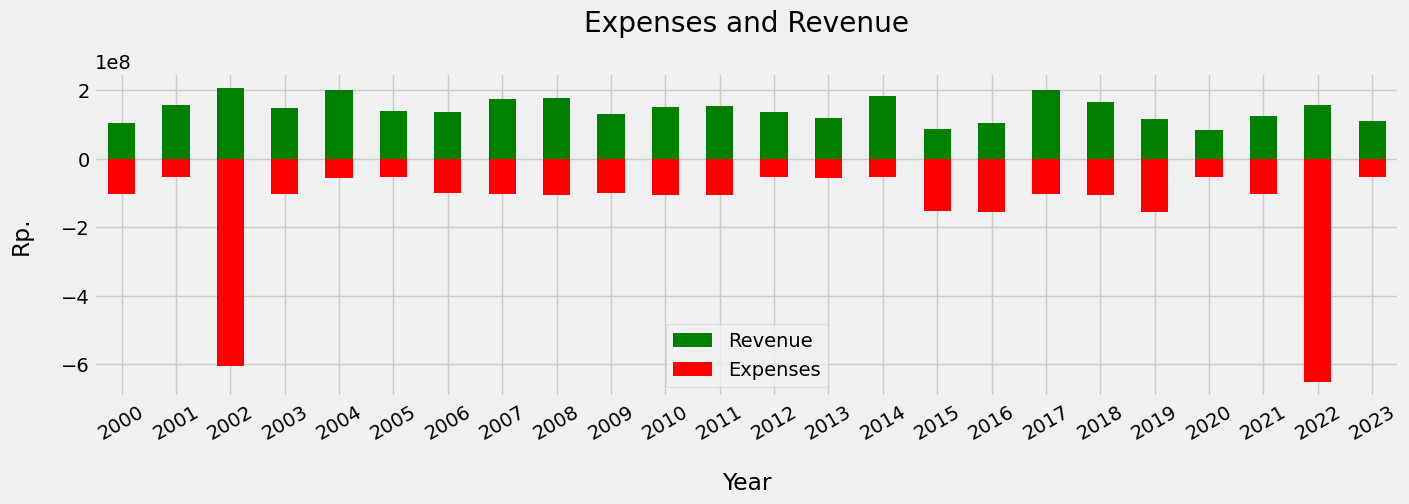

In [12]:
revenue.plot(kind='bar', figsize=(15, 4), color='green')
(-expenses).plot(kind='bar', figsize=(15, 4), color='red')
plt.grid(True, axis='y')
plt.title("Expenses and Revenue", pad=30)
plt.xlabel("Year", labelpad=20)
plt.ylabel("Rp.", labelpad=20)
plt.xticks(rotation=30)
plt.legend(["Revenue", "Expenses"])
plt.show()